In [34]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from itertools import product

In [35]:
query_df = pd.read_csv('Test_Data/query_dataset_4.csv')
ref_df   = pd.read_csv('Test_Data/reference_dataset_4.csv')
all_wavs_str = query_df.columns[:-1]
all_wavs_numeric = pd.to_numeric(all_wavs_str)

wavs_to_keep = all_wavs_str[all_wavs_numeric < 1700].tolist()


final_cols_to_keep = wavs_to_keep + ['Species']


query_df = query_df[final_cols_to_keep]
ref_df   = ref_df[final_cols_to_keep]


wavs_str = query_df.columns[:-1]


wavs = wavs_str.astype(float)

In [36]:
def baseline_als(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(intensities):
    out = np.zeros_like(intensities)
    for i, spec in enumerate(intensities):
        bkg = baseline_als(spec)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr/nrm if nrm!=0 else corr
    return out

In [37]:
Q_proc = preprocess(query_df[wavs_str].values.astype(float))
R_proc = preprocess(ref_df[wavs_str].values.astype(float))

dfQ = pd.DataFrame(Q_proc, columns=wavs_str)
dfQ['Species'] = query_df['Species']
dfR = pd.DataFrame(R_proc, columns=wavs_str)
dfR['Species'] = ref_df['Species']

In [38]:
K_vals    = [3]
N_vals    = [15]
W_vals    = [36]
height_vals = [0.02]
prominence_vals = [0.02]

results = []

In [39]:
for version in ['count', 'intensity']:
    for K_smooth, N_peak, w_max, height, prominence in product(K_vals, N_vals, W_vals, height_vals, prominence_vals):
        # define smoothing
        def smooth_spectrum(spec):
            return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')
        
        # define CaPE
        if version == 'count':
            def CaPE(refs):
                sm = np.array([smooth_spectrum(s) for s in refs])
                counts = np.zeros(sm.shape[1], int)
                for s in sm:
                    pks, _ = find_peaks(s, height=height, prominence=prominence)
                    counts[pks] += 1
                return sorted(np.argsort(counts)[-N_peak:])
        else:
            def CaPE(refs):
                sm = np.array([smooth_spectrum(s) for s in refs])
                intens = np.zeros(sm.shape[1])
                for s in sm:
                    pks, _ = find_peaks(s, height=height, prominence=prominence)
                    intens[pks] += s[pks]
                return sorted(np.argsort(intens)[-N_peak:])
        
        # feature extraction
        def extract_vec(spec, cp_idxs):
            hw = w_max // 2
            vals = [spec[max(0,i-hw):min(len(spec),i+hw+1)].max() for i in cp_idxs]
            return minmax_scale(vals)
        
        # build CPs and compressed references
        CPs = {}
        Ref_comp = {}
        for chem, grp in dfR.groupby('Species'):
            cp = CaPE(grp[wavs_str].values)
            CPs[chem] = cp
            Ref_comp[chem] = np.array([extract_vec(s, cp) for s in grp[wavs_str].values])
        
        # identification
        def CaPSim(qv, rvs): return (rvs @ qv).mean()
        def identify(spec):
            scores = {chem: CaPSim(extract_vec(spec, CPs[chem]), Ref_comp[chem])
                      for chem in CPs}
            sorted_chems = sorted(scores, key=scores.get, reverse=True)
            return sorted_chems
        
        # evaluate top-1 and top-2
        top1 = top2 = 0
        for _, row in dfQ.iterrows():
            preds = identify(row[wavs_str].values)
            true = row['Species']
            if true == preds[0]: top1 += 1
            if true in preds[:2]: top2 += 1
        total = len(dfQ)
        results.append({
            'version': version, 'K_smooth': K_smooth,
            'N_peak': N_peak, 'w_max': w_max, 'height': height, 'prominence': prominence,
            'top1_acc': top1/total, 'top2_acc': top2/total
        })

In [40]:
res_df = pd.DataFrame(results)
res_df = res_df.sort_values(['top1_acc', 'top2_acc'], ascending=False).head(5).reset_index(drop=True)

# Display
print("## Top 5 CaPE Parameter Settings\n")
print(res_df.to_markdown(index=False))

## Top 5 CaPE Parameter Settings

| version   |   K_smooth |   N_peak |   w_max |   height |   prominence |   top1_acc |   top2_acc |
|:----------|-----------:|---------:|--------:|---------:|-------------:|-----------:|-----------:|
| count     |          3 |       15 |      36 |     0.02 |         0.02 |   0.481667 |   0.498333 |
| intensity |          3 |       15 |      36 |     0.02 |         0.02 |   0.326667 |   0.495    |


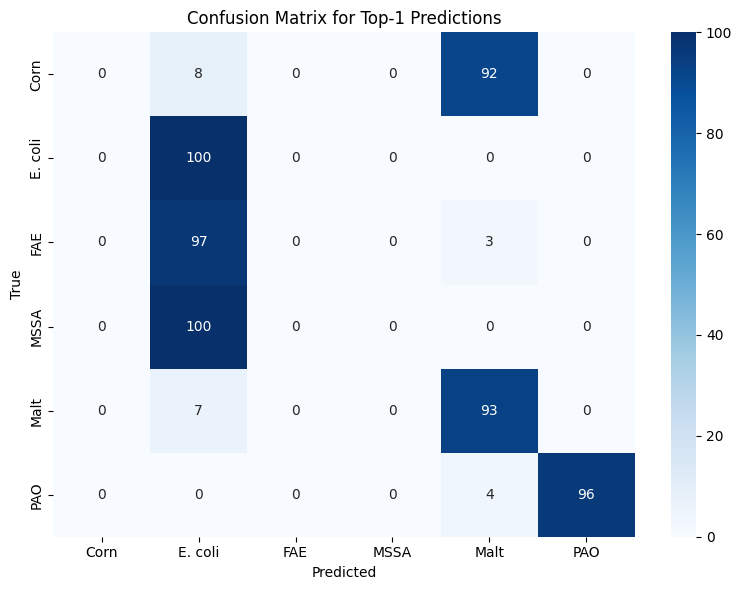

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1) Pick best model
best = res_df.iloc[0]
version    = best['version']
K_smooth   = int(best['K_smooth'])
N_peak     = int(best['N_peak'])
w_max      = int(best['w_max'])
height     = float(best['height'])
prominence = float(best['prominence'])

# 2) Re-define smooth, CaPE, extract, identify
def smooth_spectrum(spec):
    return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

if version == 'count':
    def CaPE(refs):
        sm = np.array([smooth_spectrum(s) for s in refs])
        counts = np.zeros(sm.shape[1], int)
        for s in sm:
            pks, _ = find_peaks(s, height=height, prominence=prominence)
            counts[pks] += 1
        return sorted(np.argsort(counts)[-N_peak:])
else:
    def CaPE(refs):
        sm = np.array([smooth_spectrum(s) for s in refs])
        intens = np.zeros(sm.shape[1])
        for s in sm:
            pks, _ = find_peaks(s, height=height, prominence=prominence)
            intens[pks] += s[pks]
        return sorted(np.argsort(intens)[-N_peak:])

def extract_vec(spec, cp_idxs):
    hw = w_max // 2
    return minmax_scale([spec[max(0,i-hw):i+hw+1].max() for i in cp_idxs])

# 3) Rebuild CP library
CPs, Ref_comp = {}, {}
for chem, grp in dfR.groupby('Species'):
    cp_idxs = CaPE(grp[wavs_str].values)
    CPs[chem] = cp_idxs
    Ref_comp[chem] = np.array([extract_vec(s, cp_idxs) for s in grp[wavs_str].values])

def identify_top1(spec):
    scores = {chem: (Ref_comp[chem] @ extract_vec(spec, CPs[chem])).mean()
              for chem in CPs}
    return max(scores, key=scores.get)

# 4) True vs. Predicted
true_labels = dfQ['Species'].values
pred_labels = [identify_top1(row[wavs_str].values) for _, row in dfQ.iterrows()]

# 5) Confusion Matrix
labels = sorted(dfQ['Species'].unique())
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Top-1 Predictions')
plt.tight_layout()
plt.show()
